In [1]:
from PIL import Image
from itertools import product
import os
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import csv

In [2]:
PATCH_IMAGE_SIZE = 256//64
SOURCE_DIR = 'datasets/PlantVillage/Original'

In [3]:
def tile(filename, dir_in, d):
    patches = []
    name, ext = os.path.splitext(filename)
    try:
        img = Image.open(os.path.join(dir_in, filename))
    except:
        print('Could not open image: ', filename)
        return
    w, h = img.size

    grid = product(range(0, h-h % d, d), range(0, w-w % d, d))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        # out = os.path.join(dir_out, f'{name}_{i}_{j}{ext}')
        patches.append(img.crop(box))
    return patches

In [4]:
features, labels = [], []
file_count = 0

In [5]:
subfolders = [f.path for f in os.scandir(SOURCE_DIR) if f.is_dir()]
for subfolder in subfolders:
    # dist_folder = os.path.join(DIST_DIR, os.path.basename(subfolder))
    # if not os.path.exists(dist_folder):
    #     os.makedirs(dist_folder)
    files = os.listdir(subfolder)
    for file in files:
        print("Processing file: ", file)
        file_count += 1

        # create patches
        m_patches = tile(file, subfolder, PATCH_IMAGE_SIZE)

        # convert to numpy array
        m_patches = [np.array(patch) for patch in m_patches]

        # extract features
        m_features = [patch.flatten() for patch in m_patches]

        # we have 16 features per image, with 16 same labels
        for f in m_features:
            features.append(f)
            labels.append(os.path.basename(file))

Processing file:  00a7c269-3476-4d25-b744-44d6353cd921___GCREC_Bact.Sp 5807.JPG
Processing file:  00b7e89a-e129-4576-b51f-48923888bff9___GCREC_Bact.Sp 6202.JPG
Processing file:  01a3cf3f-94c1-44d5-8972-8c509d62558e___GCREC_Bact.Sp 3396.JPG
Processing file:  01a46cb5-d354-4f59-868e-e56186701541___GCREC_Bact.Sp 5638.JPG
Processing file:  01d7f4fe-793f-4a9b-bc8b-8aa05200984f___GCREC_Bact.Sp 2984.JPG
Processing file:  01d9fc8d-5083-468d-a583-885f33517cdd___GCREC_Bact.Sp 3422.JPG
Processing file:  01e079ba-939a-4681-8983-db663f4a859b___GCREC_Bact.Sp 3029.JPG
Processing file:  01f13167-f508-4ef2-8720-4e973438f8fc___GCREC_Bact.Sp 5892.JPG
Processing file:  0a1655ed-797c-4d1d-ba35-dc255d68a2ee___GCREC_Bact.Sp 3560.JPG
Processing file:  0a22f50a-5f25-4cf6-816b-76cae94b7f30___GCREC_Bact.Sp 6103.JPG
Processing file:  0a64655c-4052-4e5f-a696-2a6cf25d10c9___GCREC_Bact.Sp 6017.JPG
Processing file:  0a6d40e4-75d6-4659-8bc1-22f47cdb2ca8___GCREC_Bact.Sp 6247.JPG
Processing file:  0aa1c431-682b-4a6e-af5

In [6]:
print("Features: ", len(features))
print("Labels: ", len(labels))
print("File count: ", file_count)

Features:  4096000
Labels:  4096000
File count:  1000


In [7]:
# find the optimal number of clusters
wcss = [] 
for number_of_clusters in range(1, 11): 
    print("Trying for number of clusters: ", number_of_clusters)
    kmeans = KMeans(n_clusters = number_of_clusters, random_state = 42)
    kmeans.fit(features) 
    wcss.append(kmeans.inertia_)
wcss

Trying for number of clusters:  1
Trying for number of clusters:  2
Trying for number of clusters:  3
Trying for number of clusters:  4
Trying for number of clusters:  5
Trying for number of clusters:  6
Trying for number of clusters:  7
Trying for number of clusters:  8
Trying for number of clusters:  9
Trying for number of clusters:  10


[427737684654.7437,
 200038099528.33533,
 148414842488.59668,
 124999912564.55582,
 113811836323.125,
 105511442310.47075,
 99569636937.47546,
 95493368422.58786,
 92604001918.69893,
 90072535162.11275]

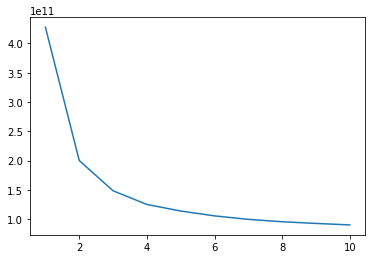

In [8]:
#plot
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.plot(ks, wcss)

In [9]:
# Creating Clusters
k = 3
kmean = KMeans(k, random_state=40)
kmean.fit(features)

KMeans(n_clusters=3, random_state=40)

In [10]:
clusters_labels = kmean.predict(features)
print(clusters_labels)

[0 0 0 ... 2 2 2]


In [11]:
files = glob.glob(SOURCE_DIR + '/*/*.JPG')
print(len(files))

1000


In [12]:
files_clusters = dict()
for f in files:
    filename = os.path.basename(f)
    files_clusters[filename] = dict()
    files_clusters[filename]['clusters'] = [0 for i in range(3)]

cluster_count = [0 for i in range(3)]

for i in range(len(labels)):
    label = labels[i]
    cluster = clusters_labels[i]
    files_clusters[label]['clusters'][cluster] += 1
    cluster_count[cluster] += 1
    

In [13]:
print("Cluster Size: ", cluster_count)
file1Cluster = files_clusters[list(files_clusters.keys())[0]]
print("File 1 Cluster: ", file1Cluster)
print("Total features per image:", sum(file1Cluster['clusters']))

Cluster Size:  [1531406, 938461, 1626133]
File 1 Cluster:  {'clusters': [1105, 2299, 692]}
Total features per image: 4096


In [14]:
# Get cluster centroids
centroids = kmean.cluster_centers_

# Initialize list to store mean distances for each cluster
mean_distances = []

# Calculate mean distance for each cluster
for i in range(3):
  points = []
  # Select points in cluster
  for j in range(kmean.labels_.size):
    l = kmean.labels_[j]
    if l == i:
      points.append(features[j])
  
  # Calculate distances between points and centroid
  print("Calculating for cluster: " + str(i))
  distances = euclidean_distances(points, centroids[i].reshape(1, -1))
  
  # Calculate mean distance
  mean_distance = np.mean(distances)
  
  # Add mean distance to list
  mean_distances.append(mean_distance)

print("Mean Distance: ", mean_distances)

Calculating for cluster: 0
Calculating for cluster: 1
Calculating for cluster: 2
Mean Distance:  [159.36915351820898, 190.9052966164844, 181.10028524498395]


In [15]:
# weights
# c = k * d/n
ce = [0 for i in range(3)]
for i in range(3):
  ce[i] = mean_distances[i]/cluster_count[i]
# normalize
cluster_coefficient = [float(i)/sum(ce) for i in ce]
print("Cluster_coefficients: ", cluster_coefficient)

Cluster_coefficients:  [0.24845363736815704, 0.48566095149104915, 0.2658854111407939]


In [16]:
# each image weight
# wi = (c1*n1 + c2*n2 + c3*n3)/(n1+n2+n3)
c1 = cluster_coefficient[0]
c2 = cluster_coefficient[1]
c3 = cluster_coefficient[2]
weights = []
for f in files:
  label = os.path.basename(f)
  fc = files_clusters[label]['clusters']

  w = ( c1*fc[0] + c2*fc[1] + c3*fc[2] ) / (fc[0] + fc[1] + fc[2])
  weights.append(w)
  # files_clusters[label]['weight'] = w


In [17]:
#  weight normalization
norm_weights = [float(i)/sum(weights) for i in weights]

# write to csv
idx = 0
header = ['file_name', 'weight']
with open('weights.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(header)
  for f in files:
    label = os.path.basename(f)
    writer.writerow([label, norm_weights[idx]])
    idx += 1  